<a href="https://colab.research.google.com/github/Shalinid8/RNA_Squence_Analysis/blob/main/Single_Cell_Gene_Expression_Scanpy.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [ ]:
!pip install scanpy

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/


In [ ]:
!pip install igraph

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/


In [ ]:
!pip install louvain

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/


In [ ]:
import scanpy as sc
import numpy as np
import pandas as pd

In [ ]:
sc.settings.verbosity = 3
sc.settings.set_figure_params(dpi=80)
sc.logging.print_versions()
results_file='/content/pmbc3k.h5ad'

-----
anndata     0.9.1
scanpy      1.9.3
-----
PIL                 8.4.0
astunparse          1.6.3
backcall            0.2.0
certifi             2022.12.07
cffi                1.15.1
cloudpickle         2.2.1
cycler              0.10.0
cython_runtime      NA
dask                2022.12.1
dateutil            2.8.2
debugpy             1.6.6
decorator           4.4.2
defusedxml          0.7.1
dot_parser          NA
fsspec              2023.4.0
google              NA
h5py                3.8.0
httplib2            0.21.0
igraph              0.10.4
ipykernel           5.5.6
ipython_genutils    0.2.0
jinja2              3.1.2
joblib              1.2.0
kiwisolver          1.4.4
llvmlite            0.39.1
louvain             0.8.0
markupsafe          2.1.2
matplotlib          3.7.1
matplotlib_inline   0.1.6
mpl_toolkits        NA
mpmath              1.3.0
natsort             8.3.1
numba               0.56.4
numexpr             2.8.4
numpy               1.22.4
nvfuser             NA
opt_einsum  

In [ ]:
!gunzip '/content/barcodes.tsv.gz'

gzip: /content/barcodes.tsv.gz: No such file or directory


In [ ]:
adata =sc.read('/content/matrix.mtx',cache=True).T
adata.var_names = pd.read_csv('/content/genes.tsv',header =None, sep = '\t')[1]
adata.obs_names = pd.read_csv('/content/barcodes.tsv',header =None)[0]



... reading from cache file cache/content-matrix.h5ad


In [ ]:
adata.var_names_make_unique()

In [ ]:
sc.pp.filter_cells(adata, min_genes =200)
sc.pp.filter_genes(adata, min_cells =3)

filtered out 19024 genes that are detected in less than 3 cells


In [ ]:
mito_genes =[name for name in list(adata.var_names) if name.startswith('MT-')]
adata.obs['percent_mito'] = np.sum(adata[:,mito_genes].X, axis =1).A1/np.sum(adata.X,axis =1).A1
adata.obs['n_counts'] = adata.X.sum(axis =1).A1

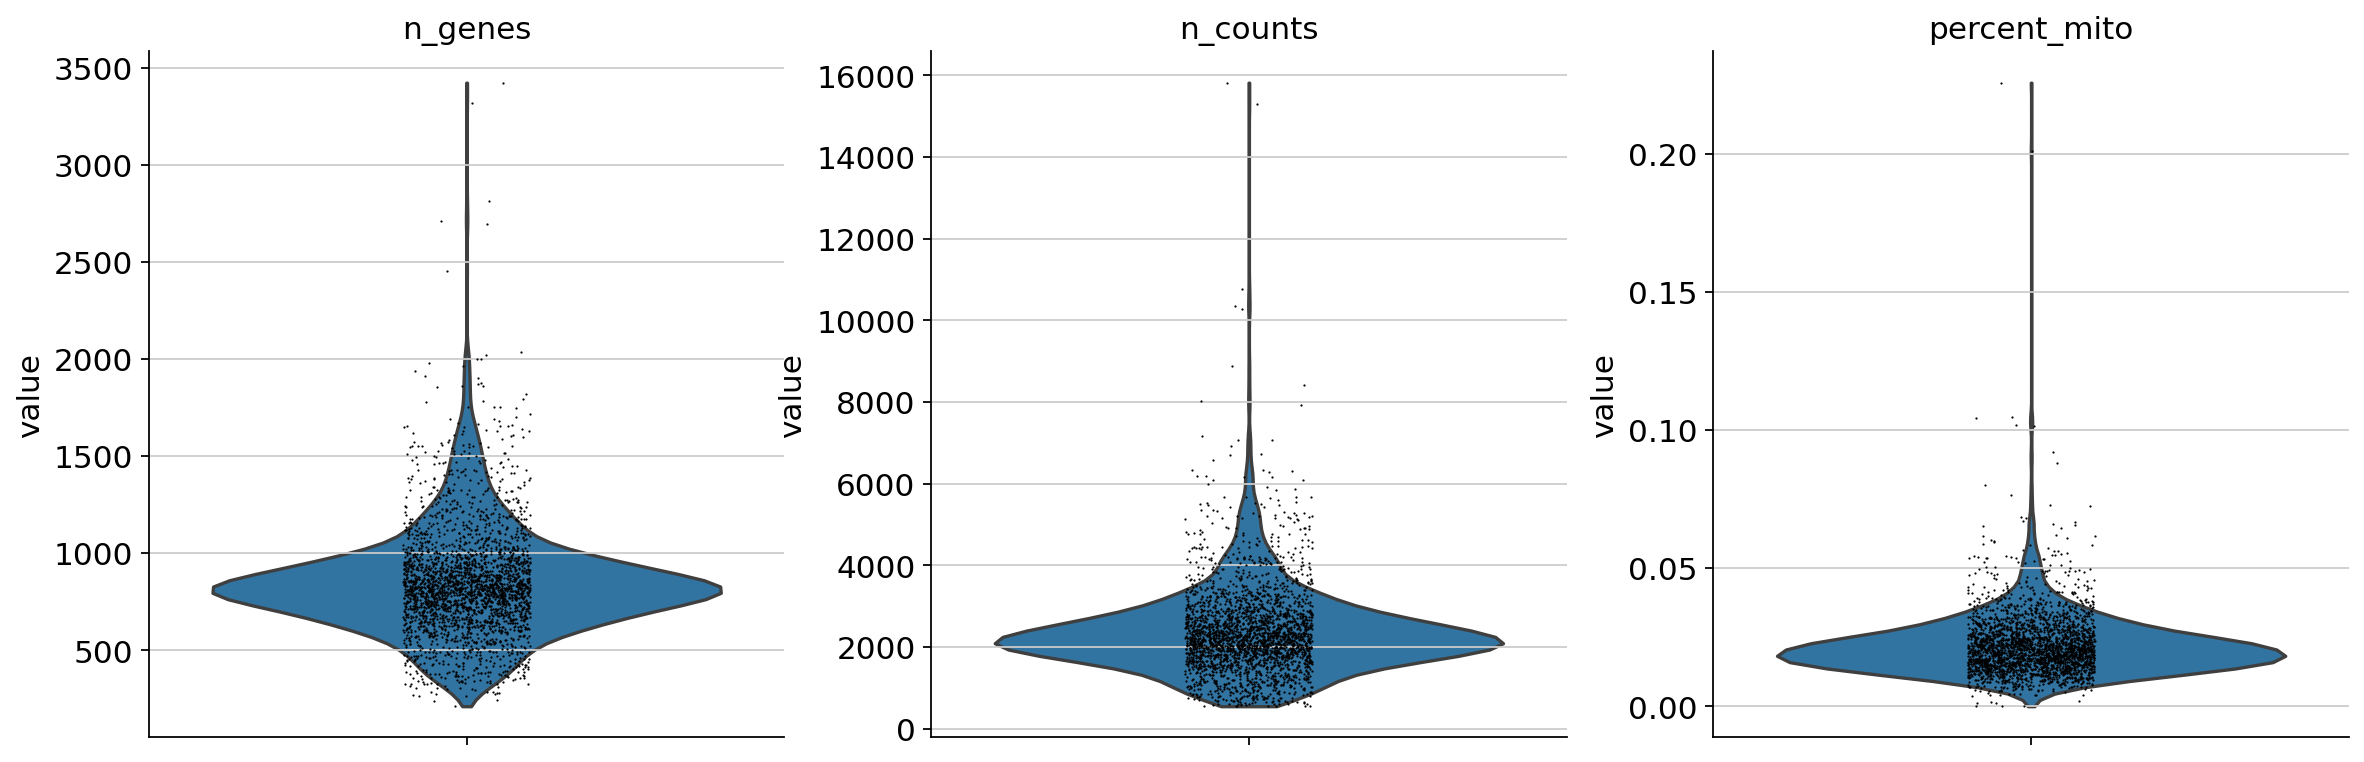

In [ ]:
sc.pl.violin(adata,['n_genes','n_counts','percent_mito'],jotter = 0.4, multi_panel = True)

In [ ]:
adata = adata[adata.obs['n_genes']<2500,:]
adata = adata[adata.obs['percent_mito']<0.05,:]

In [ ]:
adata.raw = sc.pp.log1p(adata, copy=True)

normalizing by total count per cell
    finished (0:00:00): normalized adata.X and added    'n_counts', counts per cell before normalization (adata.obs)
extracting highly variable genes
    finished (0:00:01)


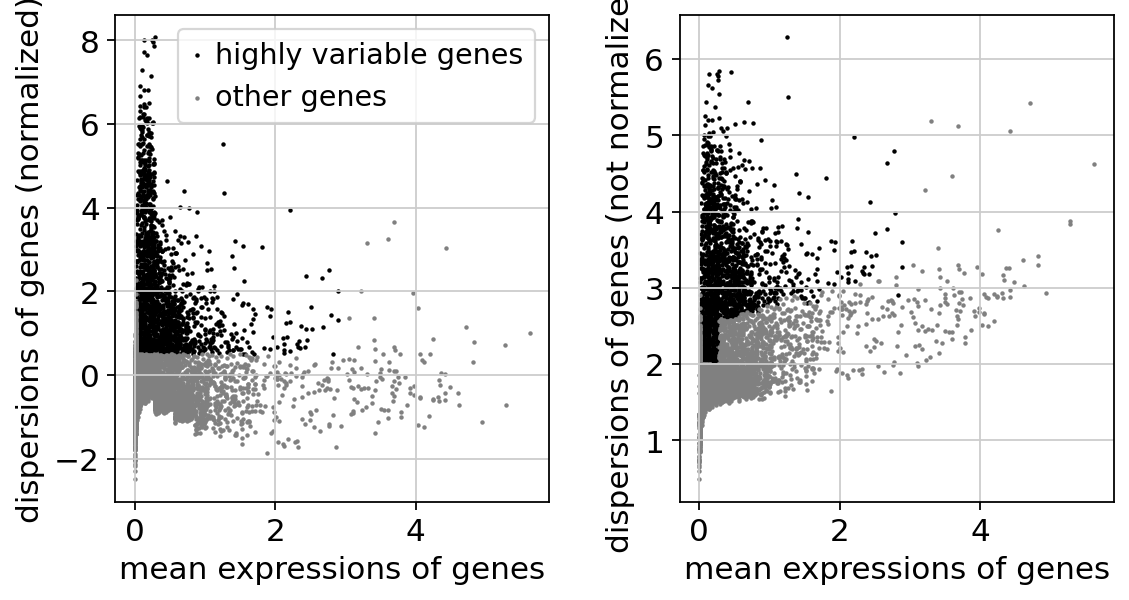

In [ ]:
sc.pp.normalize_per_cell(adata, counts_per_cell_after=1e4)
filter_result = sc.pp.filter_genes_dispersion(adata.X, min_mean = 0.0125,max_mean = 3, min_disp =0.5)
sc.pl.filter_genes_dispersion(filter_result)

In [ ]:
sum(filter_result.gene_subset)/len(filter_result.gene_subset)*100

13.402362549219776

In [ ]:
adata = adata[:,filter_result.gene_subset]
adata.shape[1]

1838

In [ ]:
sc.pp.log1p(adata)

/usr/local/lib/python3.10/dist-packages/scanpy/preprocessing/_simple.py:373: UserWarning: Received a view of an AnnData. Making a copy.
  view_to_actual(adata)


In [ ]:
sc.pp.regress_out(adata,['n_counts','percent_mito'])
sc.pp.scale(adata, max_value = 10)
adata.write(results_file)

regressing out ['n_counts', 'percent_mito']
    sparse input is densified and may lead to high memory use
    finished (0:00:08)


computing PCA
    with n_comps=50
    finished (0:00:01)


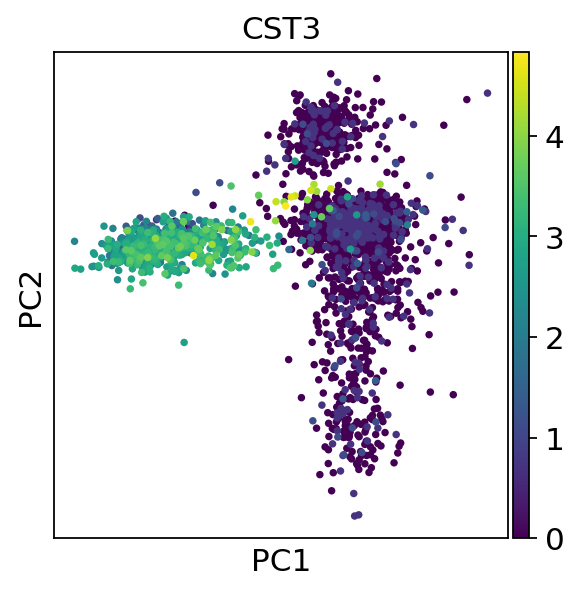

In [ ]:
sc.tl.pca(adata)
adata.obsm['X_pca'] *= -1
sc.pl.pca_scatter(adata,color = 'CST3')

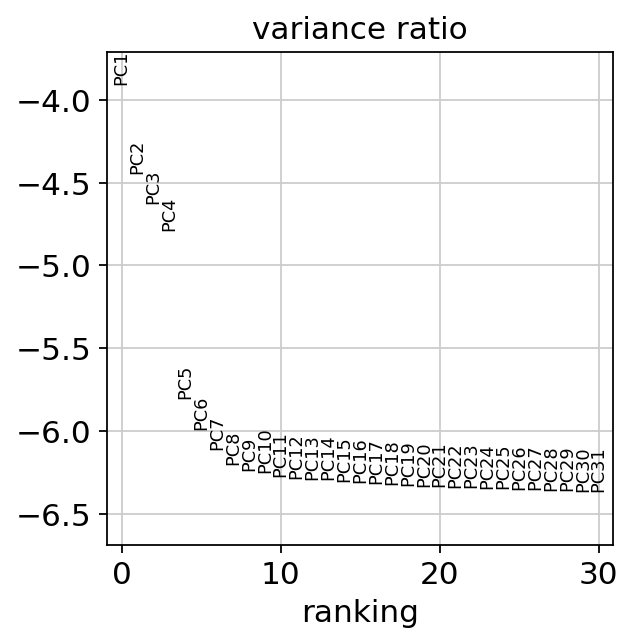

In [ ]:
sc.pl.pca_variance_ratio(adata, log= True)

In [ ]:
adata.write(results_file)
adata

AnnData object with n_obs × n_vars = 2638 × 1838
    obs: 'n_genes', 'percent_mito', 'n_counts'
    var: 'n_cells', 'mean', 'std'
    uns: 'log1p', 'pca'
    obsm: 'X_pca'
    varm: 'PCs'

In [ ]:
adata = sc.read(results_file)
sc.tl.tsne(adata, random_state = 2,n_pcs=10)
adata.write(results_file)

computing tSNE
    using 'X_pca' with n_pcs = 10
    using sklearn.manifold.TSNE
    finished: added
    'X_tsne', tSNE coordinates (adata.obsm) (0:00:28)


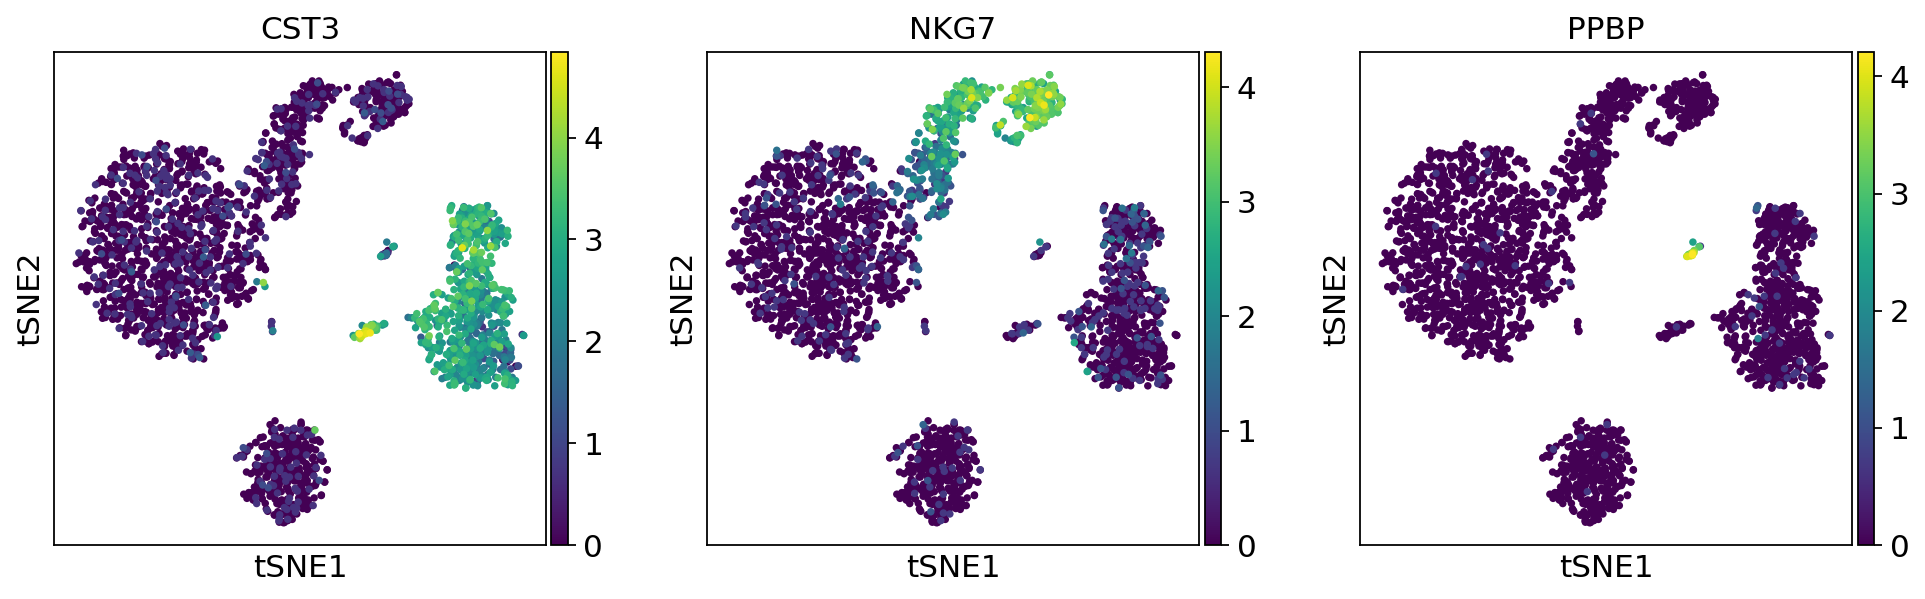

In [ ]:
sc.pl.tsne(adata, color=['CST3','NKG7','PPBP'])

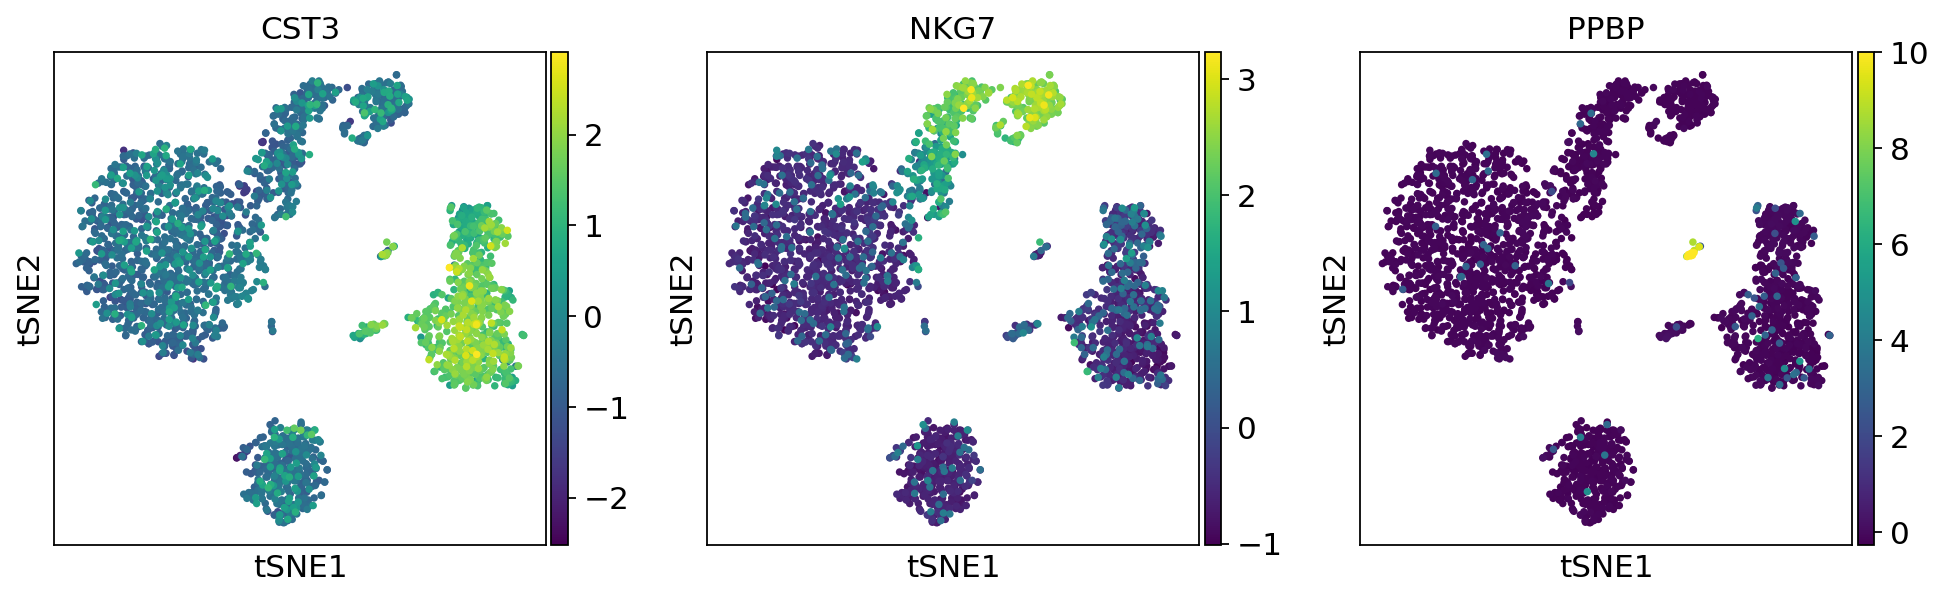

In [ ]:
sc.pl.tsne(adata, color=['CST3','NKG7','PPBP'],use_raw =False)

# **UMAP**

In [ ]:
adata = sc.read(results_file)
sc.pp.neighbors(adata,n_neighbors = 10)

computing neighbors
    using 'X_pca' with n_pcs = 50
    finished: added to `.uns['neighbors']`
    `.obsp['distances']`, distances for each pair of neighbors
    `.obsp['connectivities']`, weighted adjacency matrix (0:00:31)


computing UMAP
    finished: added
    'X_umap', UMAP coordinates (adata.obsm) (0:00:05)


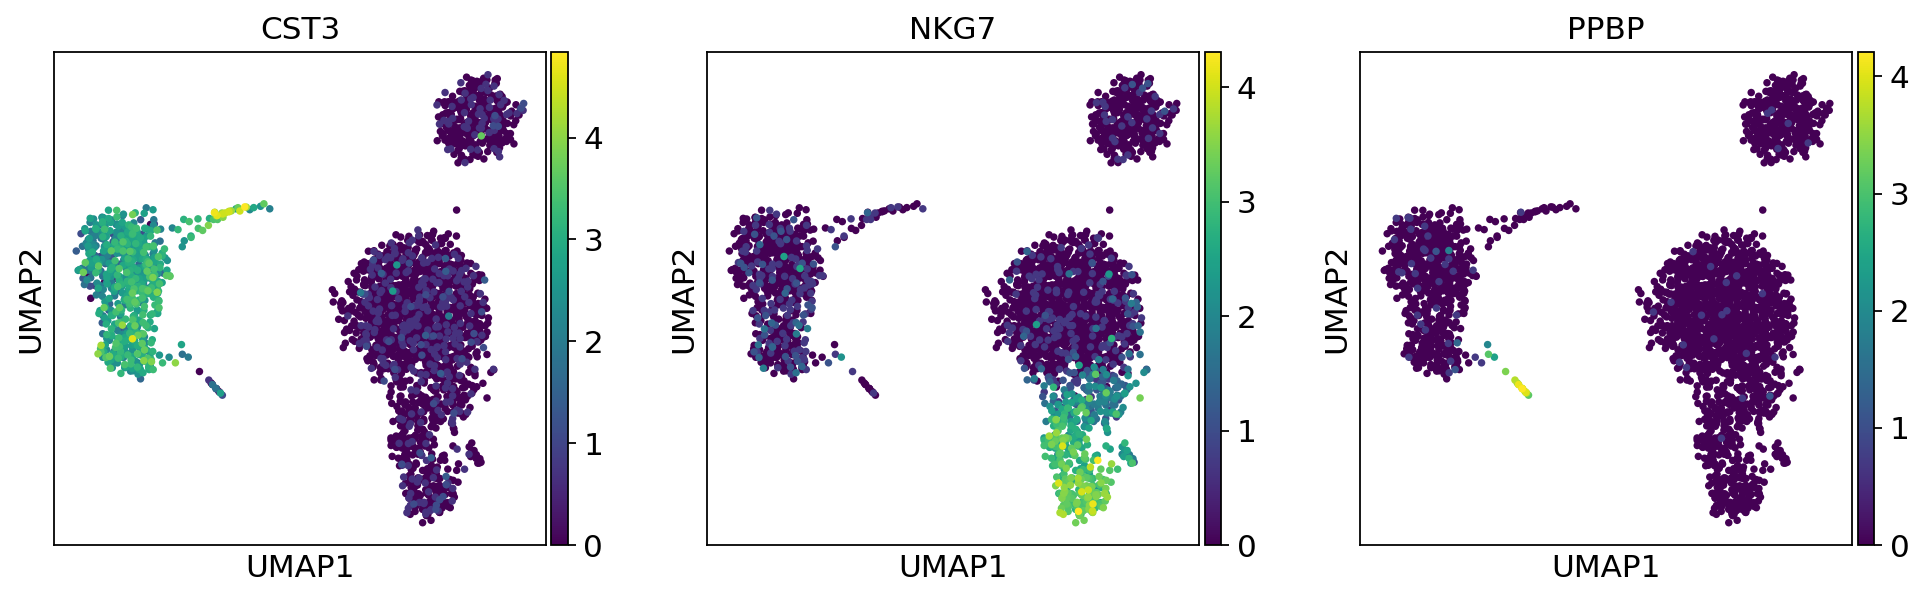

In [ ]:
sc.tl.umap(adata)
sc.pl.umap(adata, color=['CST3','NKG7','PPBP'])

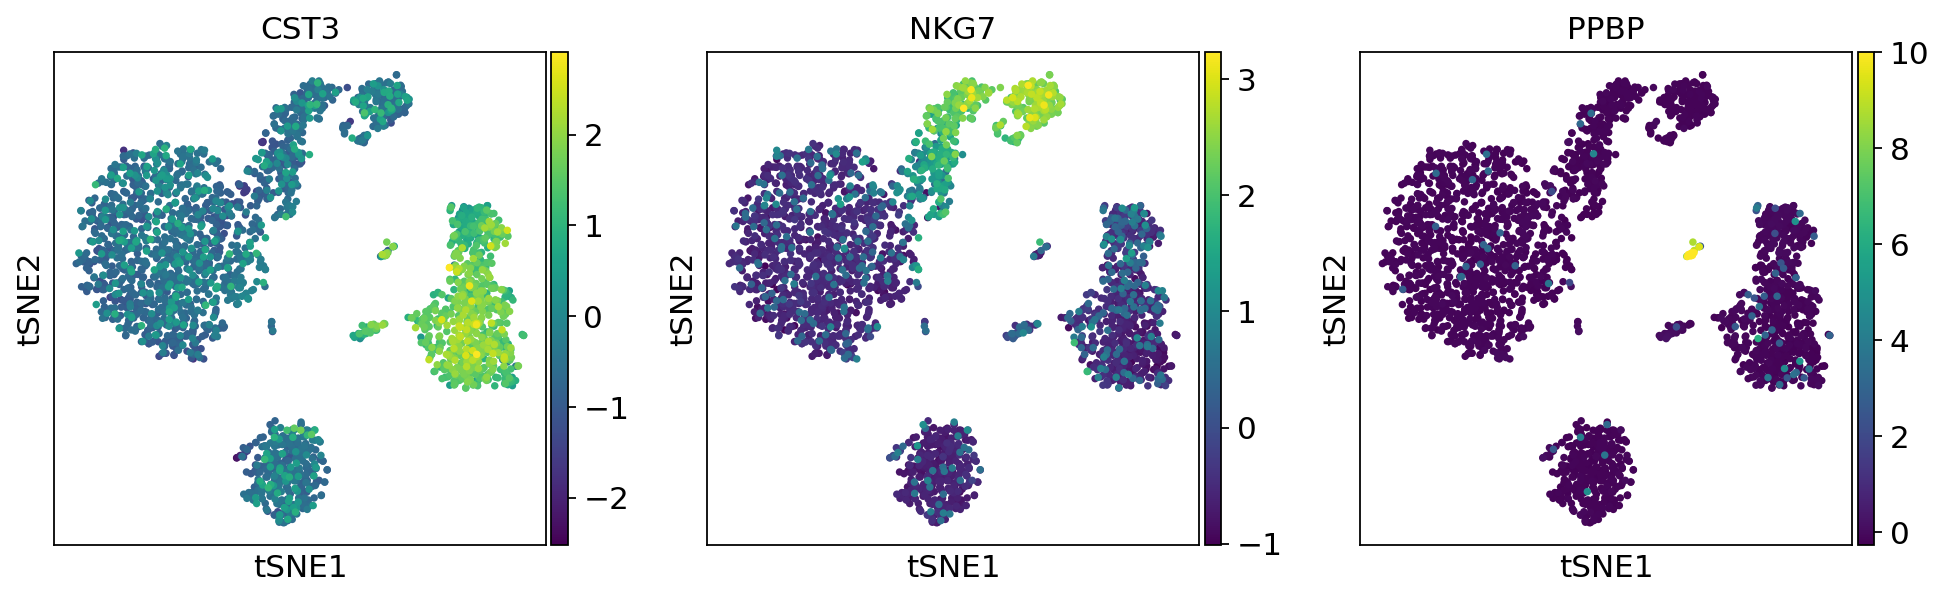

In [ ]:
sc.pl.tsne(adata, color=['CST3','NKG7','PPBP'],use_raw =False)

# **Clustering**

In [ ]:
import community
sc.tl.louvain(adata)

running Louvain clustering
    using the "louvain" package of Traag (2017)
    finished: found 7 clusters and added
    'louvain', the cluster labels (adata.obs, categorical) (0:00:00)


/usr/local/lib/python3.10/dist-packages/scanpy/plotting/_tools/scatterplots.py:392: UserWarning: No data for colormapping provided via 'c'. Parameters 'cmap' will be ignored
  cax = scatter(


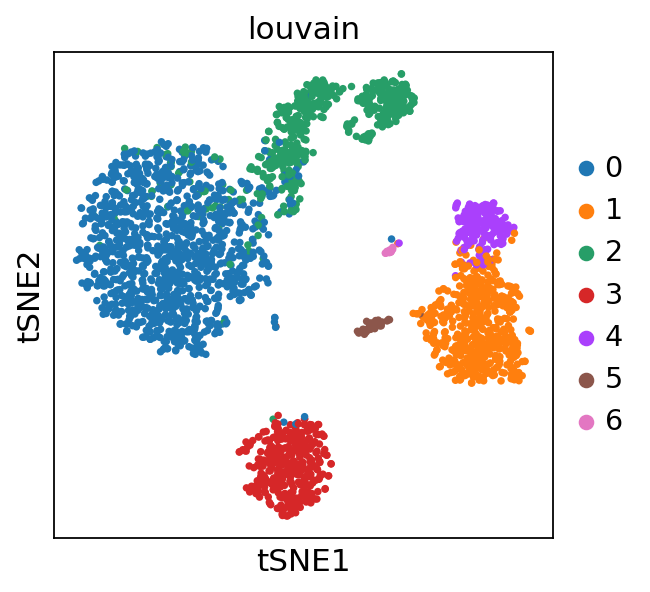

In [ ]:
sc.pl.tsne(adata, color='louvain')

/usr/local/lib/python3.10/dist-packages/scanpy/plotting/_tools/scatterplots.py:392: UserWarning: No data for colormapping provided via 'c'. Parameters 'cmap' will be ignored
  cax = scatter(


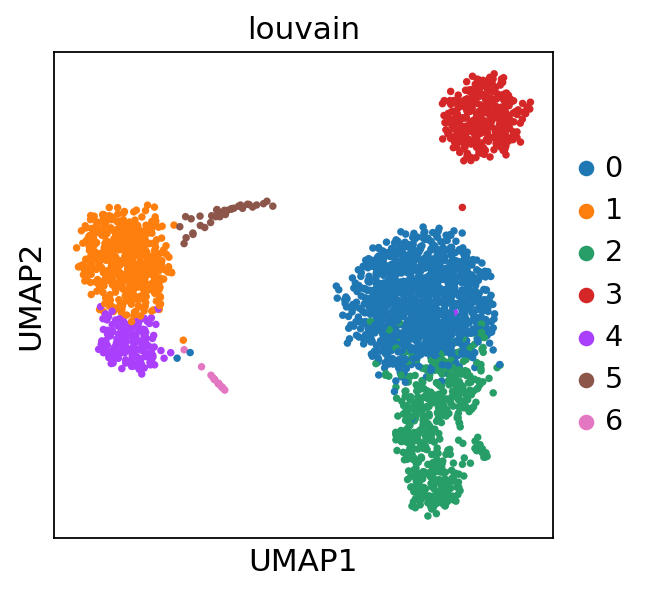

In [ ]:
sc.pl.umap(adata, color='louvain')

In [ ]:
adata.write(results_file)

ranking genes


/usr/local/lib/python3.10/dist-packages/scanpy/preprocessing/_simple.py:352: RuntimeWarning: invalid value encountered in log1p
  np.log1p(X, out=X)


    finished (0:00:00)


/usr/local/lib/python3.10/dist-packages/scanpy/tools/_rank_genes_groups.py:420: RuntimeWarning: invalid value encountered in log2
  self.stats[group_name, 'logfoldchanges'] = np.log2(
/usr/local/lib/python3.10/dist-packages/scanpy/tools/_rank_genes_groups.py:420: RuntimeWarning: invalid value encountered in log2
  self.stats[group_name, 'logfoldchanges'] = np.log2(
/usr/local/lib/python3.10/dist-packages/scanpy/tools/_rank_genes_groups.py:420: RuntimeWarning: invalid value encountered in log2
  self.stats[group_name, 'logfoldchanges'] = np.log2(


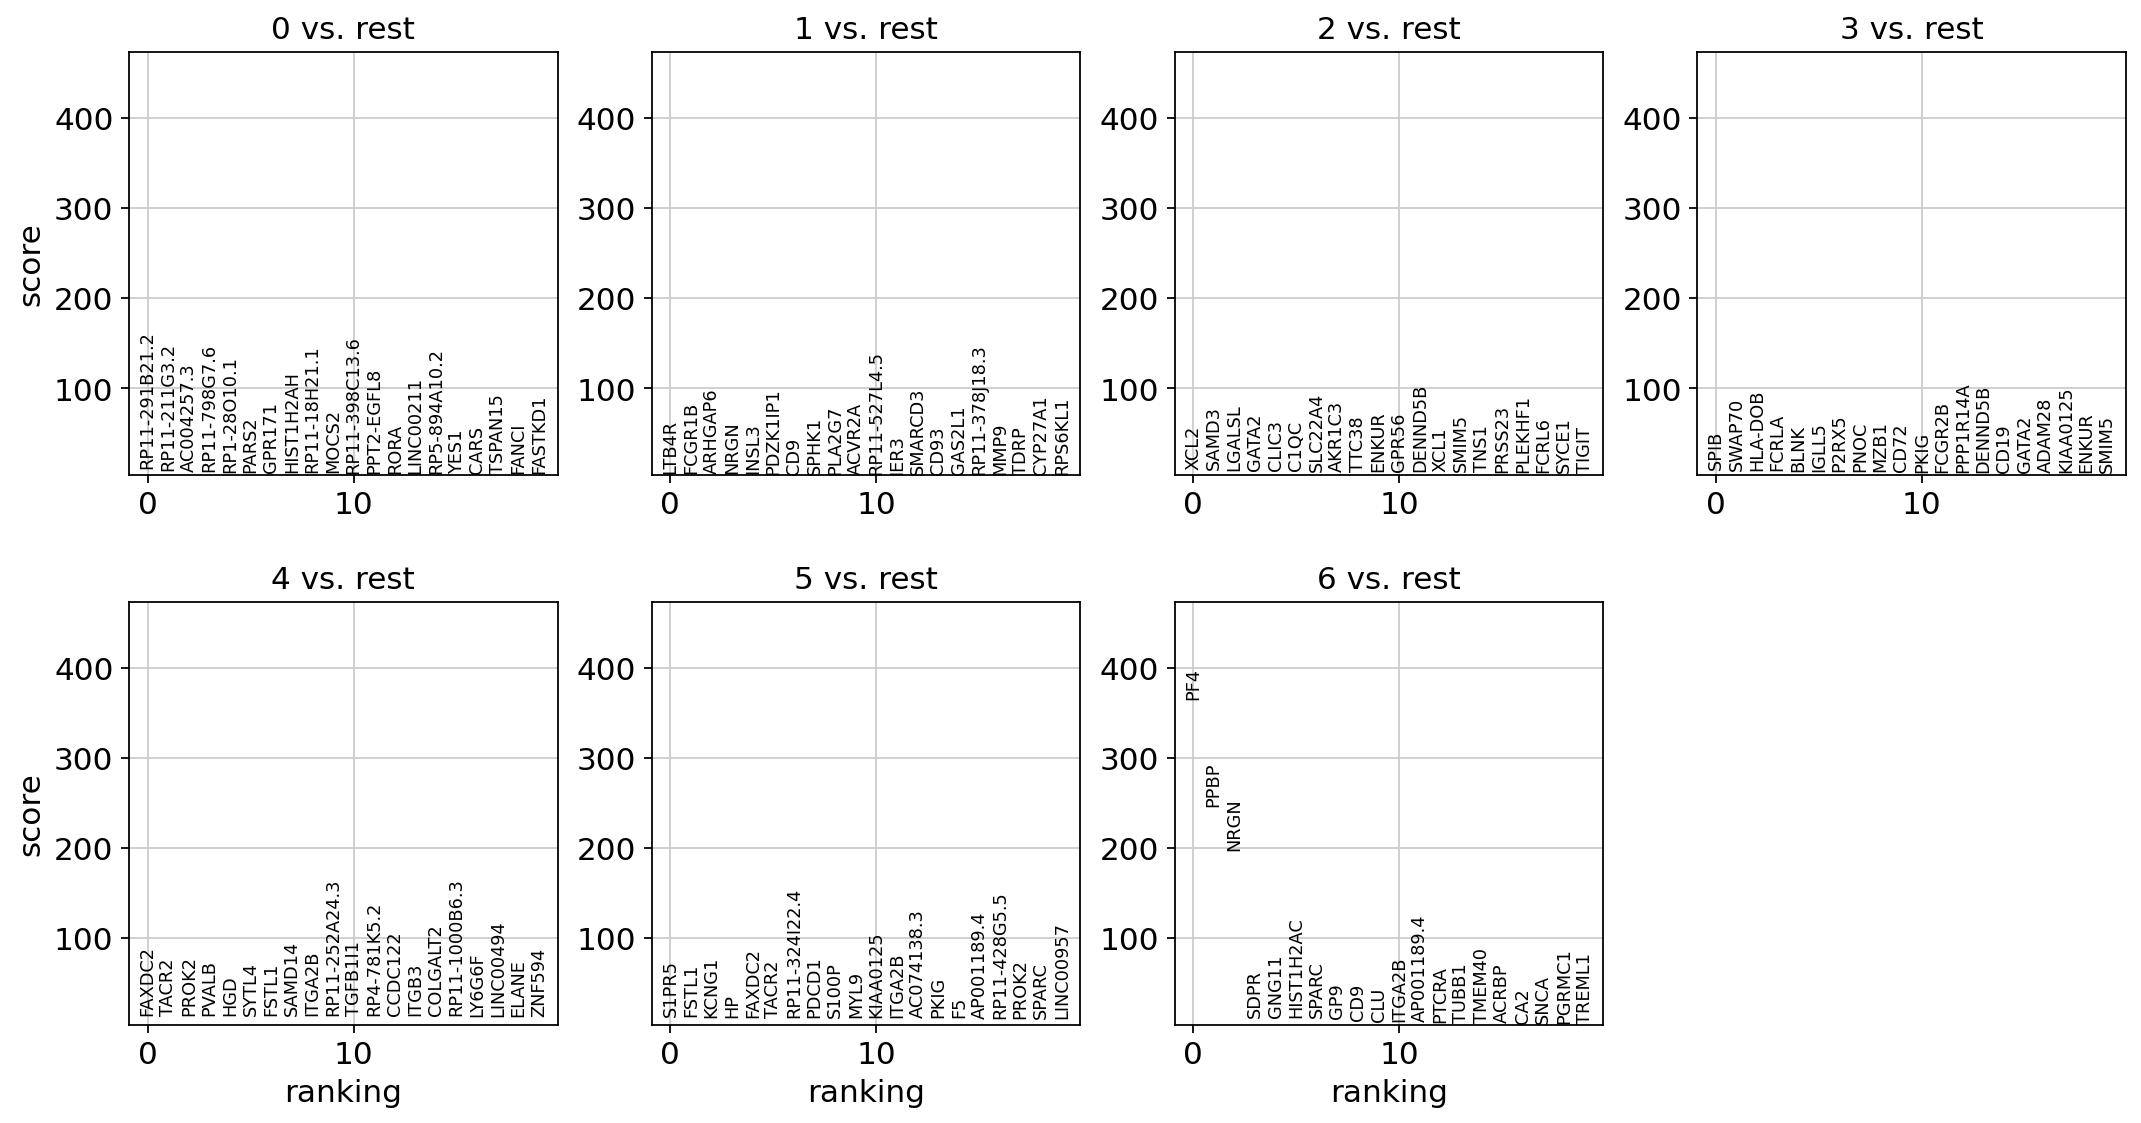

In [ ]:
adata = sc.read(results_file)
adata.raw = adata  # Store the raw data in the `.raw` attribute
sc.pp.log1p(adata)
sc.tl.rank_genes_groups(adata, 'louvain')
sc.pl.rank_genes_groups(adata, n_genes=20, save ='.pdf')
adata.write(results_file)



In [ ]:
sc.settings.verbosity =2

In [ ]:
pd.DataFrame(adata.uns['rank_genes_groups']['names']).head(5)

,0,1,2,3,4,5,6
0,RP11-291B21.2,LTB4R,XCL2,SPIB,FAXDC2,S1PR5,PF4
1,RP11-211G3.2,FCGR1B,SAMD3,SWAP70,TACR2,FSTL1,PPBP
2,AC004257.3,ARHGAP6,LGALSL,HLA-DOB,PROK2,KCNG1,NRGN
3,RP11-798G7.6,NRGN,GATA2,FCRLA,PVALB,HP,SDPR
4,RP1-28O10.1,INSL3,CLIC3,BLNK,HGD,FAXDC2,GNG11


In [ ]:
result = adata.uns['rank_genes_groups']
groups = result['names'].dtype.names
pd.DataFrame({group +'_'+key[:1]:result[key][group]
              for group in groups for key in ['names','scores']}).head(5)

,0_n,0_s,1_n,1_s,2_n,2_s,3_n,3_s,4_n,4_s,5_n,5_s,6_n,6_s
0,RP11-291B21.2,10.803809,LTB4R,6.186959,XCL2,9.906150,SPIB,10.046135,FAXDC2,14.586057,S1PR5,13.568460,PF4,365.245087
1,RP11-211G3.2,8.751317,FCGR1B,5.964089,SAMD3,9.668344,SWAP70,9.211931,TACR2,14.562753,FSTL1,12.920407,PPBP,246.179398
2,AC004257.3,7.651864,ARHGAP6,5.755759,LGALSL,9.204006,HLA-DOB,9.048888,PROK2,14.536812,KCNG1,12.657003,NRGN,196.993057
3,RP11-798G7.6,7.605944,NRGN,5.590543,GATA2,8.980416,FCRLA,8.652362,PVALB,14.489427,HP,12.354428,SDPR,12.711904
4,RP1-28O10.1,7.401825,INSL3,5.279134,CLIC3,8.912052,BLNK,8.535692,HGD,14.485844,FAXDC2,12.155675,GNG11,12.618316


/usr/local/lib/python3.10/dist-packages/seaborn/categorical.py:166: FutureWarning: Setting a gradient palette using color= is deprecated and will be removed in version 0.13. Set `palette='dark:black'` for same effect.
  warnings.warn(msg, FutureWarning)


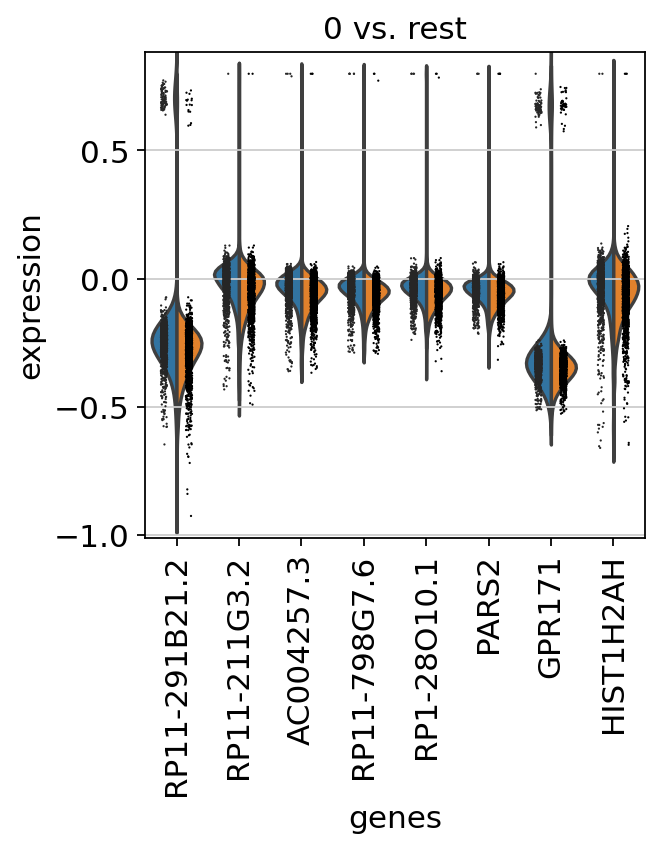

In [ ]:
sc.pl.rank_genes_groups_violin(adata, groups ='0', n_genes = 8 )

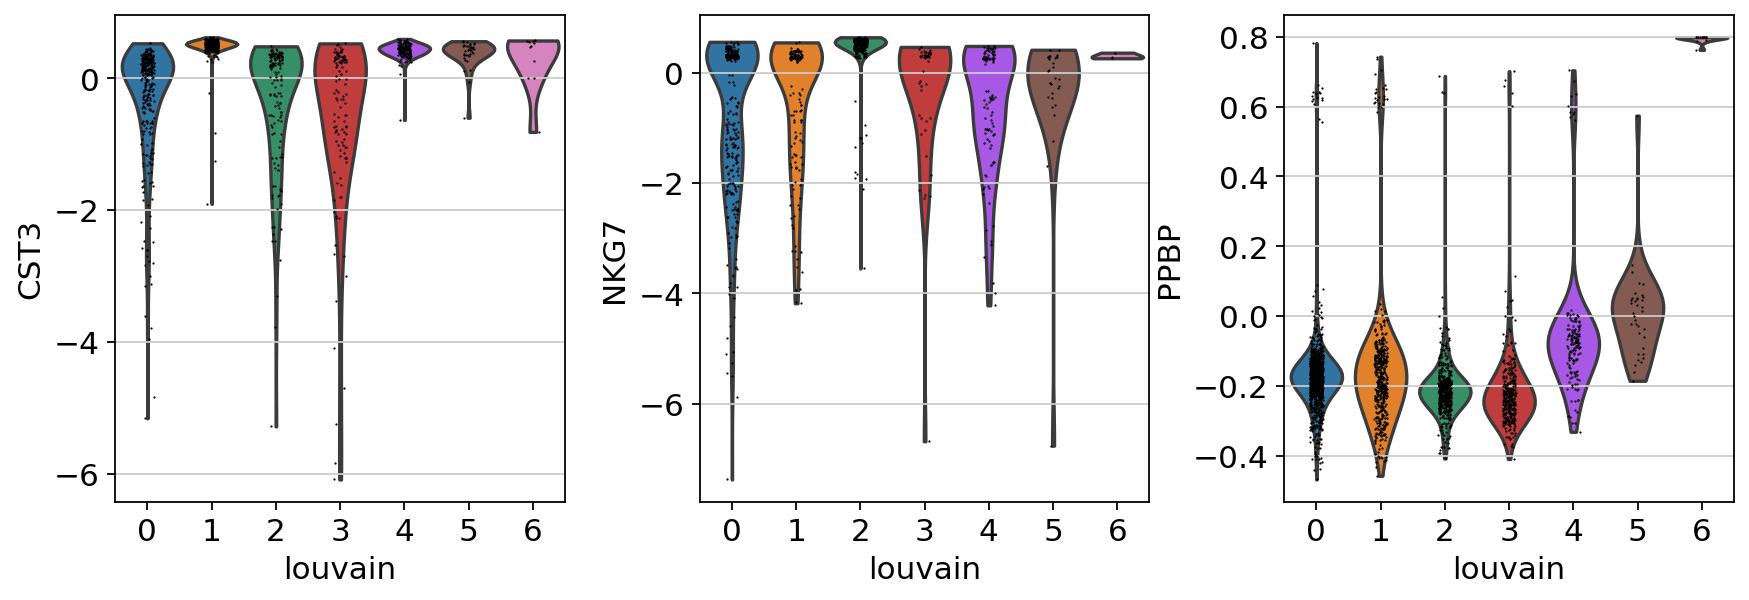

In [ ]:
sc.pl.violin(adata, ['CST3','NKG7','PPBP'], groupby = 'louvain')

In [ ]:
adata

AnnData object with n_obs × n_vars = 2638 × 1838
    obs: 'n_genes', 'percent_mito', 'n_counts', 'louvain'
    var: 'n_cells', 'mean', 'std'
    uns: 'log1p', 'louvain', 'louvain_colors', 'neighbors', 'pca', 'rank_genes_groups', 'tsne', 'umap'
    obsm: 'X_pca', 'X_tsne', 'X_umap'
    varm: 'PCs'
    obsp: 'connectivities', 'distances'

In [ ]:
adata.write(results_file)